# Workflow for Kinetochor Tracking

This is an interactive python workflow for Kinetochor Tracking. The input parameters be given using a configuration ('.yml') file, <br>
optionally some can be changed interactively during the workflow. In any case, they will be documented in a log-files.

The output data will be stored in an analysis folder, as specified in the configuration file. 

Cells where user input should be changed (e.g. the configuration file) are marked in <font color=red>red</font>. <br>
Cells where the user may interact with the data are marked in <font color=yellow>yellow</font>. <br>
Cells where the user should check some intermediate steps are marked in <font color=green>green</font>. <br>
This is only recommended when running the script for the first time. <br>
The segmentation and tracking steps can be performed seperately and are labelled in capital letters in <font color=#38ACEC>BLUE</font>. <br>
In any case, you have to load the configuration file and make the imports at the top of this file. <br>
The pipeline was developped such, that it is possible to perform the segmentation, tracking and analysis steps independently. <br>
Intermediate results will be saved in the analysis folder.

# <font color=#38ACEC>IMPORT SECTION</font>
## Import some useful Jupyter lab 'magic commands'
If this section is reevaluated, there is an additional comment that the autoreload extension is already loaded. This can be ignored.

In [2]:
# import all modules required and activate some Jupyter Notebook extensions
%load_ext autoreload
# use: %autoreload 2 to reload all external functions/modules before executing a specific part of code
%matplotlib widget

## <font color=red>Specify the configuration file</font>
You can either specify the configuration file manually or select it by clicking it using a dialog. If you want to use the latter option, use "" as a filename<br>
<code>config_file = ""</code> <br>
or simply don't specify it at all. If you want to only load a certain time-range, but not change it in the .yml file, you can change it in the end of the section using p.time_points = range(start, stop, step), where the "start" and "stop" define your start and end frames and "step" the step in between these.

In [3]:
import read_in_config_file

# define the configuration file
config_file = ""
try:
    if config_file == "":
        config_file = read_in_config_file.gui_file_name()
except NameError:
    config_file = read_in_config_file.gui_file_name()

p = read_in_config_file.read_in_config_file(config_file)
p.time_points=range(70,80)

The config file is: C:/Users/janaw/Documents/GitHub/kinetochore-tracking/Explanation_and_sample_files/sample_configuration_file_for_tracking.yml
Excel: Tracking starts in frame 60
Excel: Tracking ends in frame 152


# <font color=#38ACEC>SEGMENTATION SECTION</font>

## <font color=green>Display the model used
Depending on your qt version, there might be a warning "CreateFontFaceFromHDMC() failed" that only states the font has changed. It can be ignored.

In [4]:
from display_functions import show_model_using_napari
show_model_using_napari(p)

## Segmentation of Kinetochores
Automatic kinetochore segmentation with parameters calculated automatically. Depending on the size of the ROI, this might take a while, <br>
there will be small bars displayed for every frame. Information on this segmentation will be stored in the log-file. <br>
The name of the log-file is specified in the configuration file. <br>
It can be found in the 'analysis folder' which is also specified in the configuration file.

In [5]:
# run the kinetochore_segmentation python script
%autoreload 2
import kinetochore_segmentation_with_points_object as kin_seg
thresholds_dict, point_objects =  kin_seg.segment_kinetochores(p)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:47<00:00, 10.79s/it]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## <font color=red> Use an interactive interface to adjust thresholds <font color=green>
Adjust the segmentation thresholds to aim for a more precise segmentation of kinetochores. If you are satisfied with the results, <br>
press the green 'Save points (all frames)' button. If you pressed the button, your new segmentation will be used for the remainder of this notebook <br>
and the segmentation results will be saved to the analysis folder, so they can be loaded for the tracking step. <br>
There will be a file saving the new, global parameters. <br>
If you want to adjust the thresholds for a single frame and still save the results, us the 'Save points (single frame)' method. Every time this is used <br>
an additional file with the parameters for that frame is created. <br>
If you only want to adjust the parameters for a couple of frames, you can set the p.time_points parameter, by defining a range of relevant time-points. <br>
The syntax for this is p.time_points = range([start], stop[, step]), where you define the first and last time-points and the increment in-between.

In [6]:
%autoreload 2
import interact_with_segmentation_threshs_with_points_object as iastwpo
import point_object as po
thresholds_dict, point_objects = iastwpo.display_interactive_segmentation_thresholds(thresholds_dict, point_objects, p)

## <font color=yellow> Optional: Create and save a plot of points found over frame.

mean number of points found: 78.4


<Figure size 432x288 with 0 Axes>

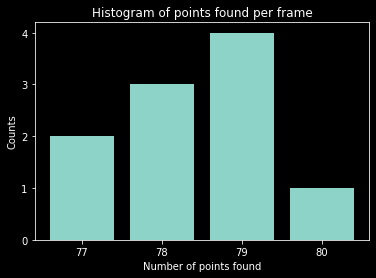

<Figure size 432x288 with 0 Axes>

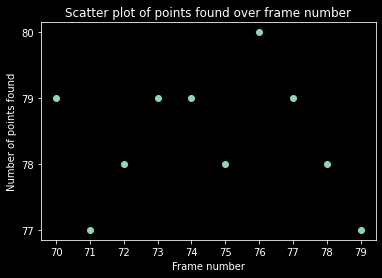

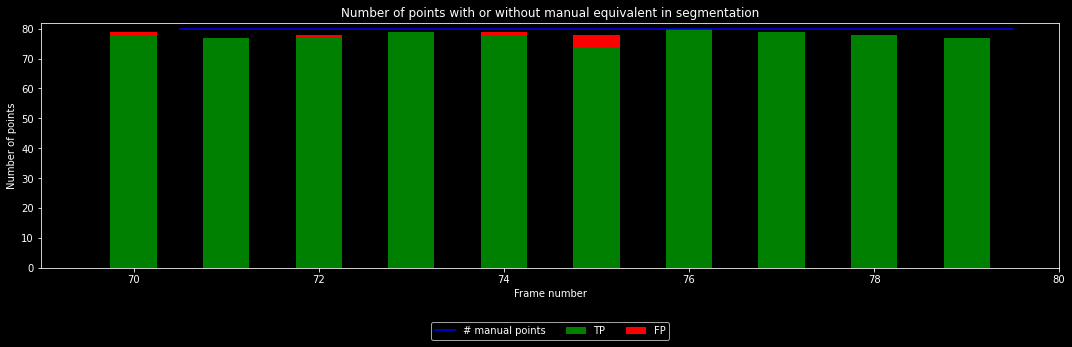

precision: 
0.9910714285714286
recall: 
0.97125


In [8]:
%matplotlib inline
%autoreload 2
from display_functions import save_plot_of_points_found_over_frame

save_plot_of_points_found_over_frame(point_objects, p, display=True)

# <font color=#38ACEC>TRACKING SECTION</font>

## <font color=yellow> Optional: Load segmentation data from file
If in a previous session, you have segmented kinetochores, you can load them in this step. Make sure your 'time points' parameter in the configuration (.yml) file specify the time range you want to analyse.

In [9]:
from load_from_and_save_to_memory import load_point_objects_from_memory 
folder = p.analysis_folder + "manually_adjusted_segmentation_points/final_segmentation/"
point_objects = load_point_objects_from_memory(p, folder=folder)

## Get the possible connections between the points, exclusion sets and the costs for each transition
For this step, make sure the anaphase onset and costs for transitions are defined in a sensible way.

In [10]:
%autoreload 2
from get_exclusion_sets import get_exclusion_sets_cm_and_cv
cost_vectors, connection_matrices, points_1_list, points_2_list, \
            indicator_split_list_point_1, indicator_split_list_point_2, sizes_1_list, sizes_2_list = get_exclusion_sets_cm_and_cv(point_objects, p)
alternative_costs_vectors = None

## <font color=yellow> Optional: Use alternative costs to also solve the linear programming problem 
(Can be used for correction later)
The measures are: <br>
    0: euclidean distance <br>
    1: intensity difference <br>
    2: area difference <br>
    3: voronoy difference <br>
    4: reverse size for split/merge <br>
    5: movement in parallel <br>

In [7]:
from distance_measures_with_exclusion_sets import CostVector
import sys, os
alternative_distance_measure_weights_list = [[0.6, 0.1, 0.05, 0.2, 0, 0.1]]


# disable printing
sys.stdout = open(os.devnull, 'w')

alternative_costs_vectors = [[] for i in range(len(alternative_distance_measure_weights_list))]
for i, (points_1, points_2, cm, points_1_indicator_split, points_2_indicator_split, sizes_1, sizes_2) \
    in enumerate(zip(points_1_list, points_2_list, connection_matrices, indicator_split_list_point_1, indicator_split_list_point_2, sizes_1_list, sizes_2_list)):
    
    for j, alternative_distance_measure_weights in enumerate(alternative_distance_measure_weights_list):
        
        if p.anaphase_onset is not None:
            is_before_anaphase = p.time_points[i+1] < p.anaphase_onset
        else:
            is_before_anaphase = True
            
        cv = CostVector(points_1,
                        points_2,
                        point_objects[i].microscopy_data,
                        point_objects[i + 1].microscopy_data,
                        cm,
                        p.metadata,
                        indicator_split_list_1=points_1_indicator_split,
                        indicator_split_list_2=points_2_indicator_split,
                        dis_appear_penalty=p.dis_appear_penalty,
                        split_merge_penalty=p.split_merge_penalty,
                        distance_measure_weights=alternative_distance_measure_weights,
                        use_dist_measure_for_transition=p.use_for_transition,
                        use_dist_measure_for_split_and_merge=p.use_for_split_merge,
                        use_dist_measure_for_appear_disappear=p.use_for_dis_appear,
                        only_use_before_anaphase_onset=p.only_use_before_anaphase_onset,
                        is_before_anaphase_onset=is_before_anaphase,
                        watershed_sizes_1=sizes_1, watershed_sizes_2=sizes_2
                        )
        alternative_costs_vectors[j].append(cv)
sys.stdout = p.standard_output_jupyter

## Solve the minimum cost flow problem (This step takes some time!) and interpret the results, also save them to files
If the linear programming problem solver does not find a solution, relax the parameters constraining the problem in the configurations file (i.e. constraint_moving, constraint_split_and_merge) and check that the segmentation step did not lead to an oversegmentation. <br>
To check how the linear programming problem solver works, you can look at the status in the terminal. If the parameters are defined to restrictively, the problem is 'INFEASIBLE'). You want the status to be <b>'OPTIMAL'</b>.  <br>
<b>Note </b>: The status bar only shows the creation of the linear programming problem. Solving it is done after it reached 100%. If you add alternative cost vectors, the solving will be done repeatedly, the creation will only be done once. <br>
Produces a "LppInterpretation" object (interpretation of the linear programming problem), in which the important tracking information is stored in python. <br>
If files with the "save to folder name" already exist, the time-stamp will be added to the .pkl file (the ending .pkl does not have to be specified). The alternative tracking results (if any) will be saved with the extension alt_(i) where (i) is the number of the alternative (starting with 0).

In [45]:
%autoreload 2
from solve_min_cost_flow_with_exclusion_sets_dict import solve_min_flow_eq_linear_programming

i_lpp, ins_and_outs, pulp_dict, test_alt_i_lpps = solve_min_flow_eq_linear_programming(connection_matrices, cost_vectors, p, True, alternative_cost_vectors=alternative_costs_vectors, points_1_list=points_1_list,
                                                                                       points_2_list=points_2_list, indicator_split_list_point_1=indicator_split_list_point_1, 
                                                                                       indicator_split_list_point_2=indicator_split_list_point_2, 
                                                                                       save_to_folder_name="lpp_interpretation_test_directly_to_folder_measure_4/lpp")

100%|███████████████████████████████████████████████████████████████████████████████| 90/90 [3:23:16<00:00, 135.51s/it]


# <font color=#38ACEC>CORRECTION SECTION</font>

## <font color=yellow> Optional: Load tracking data from file
If in a previous session you have tracked kinetochores, you can load the the tracking data from a file. Don't forget to also load the corresponding segmentation!

In [40]:
from load_from_and_save_to_memory import load_class_object_from_memory, load_point_objects_from_memory
from os_functions import try_creating_folder

# load the tracking outcome
tracking_folder = p.analysis_folder + "Tracking_outcome/linear_programming_problem_interpretation_all_direct_i_lpp.pkl"
i_lpp = load_class_object_from_memory(tracking_folder)

# try loading alternative outcomes
loaded_alt_i_lpps = []
for i in range(10):
    try:
        loaded_alt_i_lpps.append(load_class_object_from_memory(p.analysis_folder + "Tracking_outcome/linear_programming_problem_interpretation_alternative_" + str(i) + ".pkl")) # direct_i_lpp
    except FileNotFoundError:
        break

# load the segmentation
segmentation_folder = p.analysis_folder + "manually_adjusted_segmentation_points/final_segmentation/"
point_objects = load_point_objects_from_memory(p, folder=segmentation_folder)

# make sure all folders exist (in case the "create plots" cell wasn't run)
p.tracking_outcome_folder = p.analysis_folder + "Tracking_Outcome_Plots/"
try_creating_folder(p.tracking_outcome_folder)
p.tracking_distance_plot_folder = p.analysis_folder + "Tracking_distance_plots/"
try_creating_folder(p.tracking_distance_plot_folder)
p.tracking_pair_plot_folder = p.analysis_folder + "Tracking_pair_plots/"
try_creating_folder(p.tracking_pair_plot_folder)

Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_Outcome_Plots/ failed. It might already exist.
Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_distance_plots/ failed. It might already exist.
Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_pair_plots/ failed. It might already exist.


## Create plots helping the interpretation of the accuracy of the tracking
The outcome of this cell contains a lot of "Canvas(toolbar=Toolbar(..." lines, which is a little bug resulting from closing the plots in python. They are closed to keep this Notebook a little more neat.

Successfully created the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_Outcome_Plots_latex_style/ 
Successfully created the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_distance_plots_latex_style/ 
Successfully created the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_pair_plots_latex_style/ 
Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_Outcome_Plots/ failed. It might already exist.
Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_distance_plots/ failed. It might already exist.


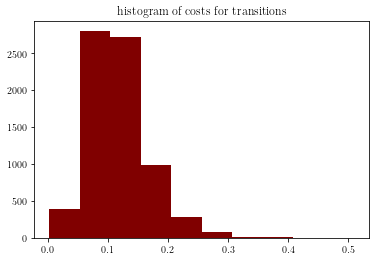

In [48]:
%matplotlib inline
%autoreload 2
from os_functions import try_creating_folder
p.tracking_outcome_folder = p.analysis_folder + "Tracking_Outcome_Plots_latex_style/"
try_creating_folder(p.tracking_outcome_folder)
p.tracking_distance_plot_folder = p.analysis_folder + "Tracking_distance_plots_latex_style/"
try_creating_folder(p.tracking_distance_plot_folder)
p.tracking_pair_plot_folder = p.analysis_folder + "Tracking_pair_plots_latex_style/"
try_creating_folder(p.tracking_pair_plot_folder)

from interpret_lpp import plot_tracking_outcome
plot_tracking_outcome(i_lpp, p, p.time_points)

## <font color=green>Display the outcome of the tracking step in an interactive viewer
This cell opens a napari viewer with the outcome of the tracking. When running this cell, manual tracks will be shown, if you load them. If they are not complete (e.g. you only tracked some objects) there will be warnings below telling you which object can not be found in what frame. The napari viewer shows: <br>
<dl>
  <dt><b> Two images </b> of the microscopy data at a time.</dt>
  <dd>- The image at the <span style="color: lime">first time step</span> in green and the image in the  <span style="color: red">second time step</span> in red.</dd>
  <dt><b> The points </b> of the segmentation results in both images.</dt>
  <dd>- The <span style="color: red">c</span><span style="color: orange">o</span><span style="color: yellow">l</span><span style="color: lime">o</span><span style="color: cyan">u</span><span style="color: magenta">r</span> of the points indicates which pair the point belongs to. If it is black, the pair index could not be determined, because no other track is similar enough.</dd>
  <dd> If the pair could not be assigned to a pair, the pair_label is -1 and the object is shown in black. </dd>
  <dd>- If you click on the points layer, you can choose the "display text" option to show the <mark> label </mark>of each segmented object. The label of the format is pair_number.pair_index: frame_number.object_number. For example, if the label is "20.1: 81.012" that means this is object 1 of pair 20, it was segmented as point 12 in frame 81. The pair_index can only be 1 or 2.</dd>
  <dd>- The points' edge will be coloured white, if this object was <ins>split in the tracking step</ins>. If the object was <span style="color: magenta">split in the segmentation step</span>, its edge will be highlighted in magenta. </dd>
  <dt><b> The vectors </b> of the tracking results.</dt>
    <dd>- The vectors connecting the points indicate the direction in which a kinetochore is moving. They have the same colour as the points they connect. </dd>
    <dd> If you choose to navigate using the  "N" and "L" keys, the movement in the transitions before and after the current transition will be shown with <mark> reduced opacity </mark>.  </dd>  
    <dd>- If manual tracking vectors are provided, they are highlighted in green, if a <span style="color: lime">similar vector has been found automatically</span> and red, if no <span style="color: red">no similar vector could be found </span>. </dd>
</dl>    

<b> Navigation as a User </b>
<ul>
    <li> As the vector layers can not be added as a multidimensional object, you can either navigate with the "N" and "L" keys on your keyboard to show the <mark>next/ last frame </mark> and automatically update the vectors, or you can use the "frame" slider at the bottom (or your &#8592 and &#8594 keys) to change the image and points and then manually select the corresponding vectors layer. </li>      
    <li> As a user, you can <mark> highlight pairs </mark> using the 'Highlight Pair Number' slider on the right. This will make the selected pair bigger and all other pairs smaller. Additionally, it will show you a plot of the coordinates of each pair over the frame number. If you do not want any pair to be highlighted, move the slider to the very left. This will make all points the same size. </li>

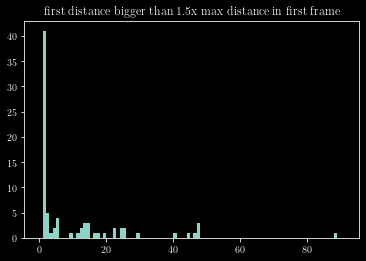

Too many indices corresponding to object41.0 in the manual tracking indices
No corresponding object found to object 71.0 in the manual tracking indices
Too many indices corresponding to object7.0 in the manual tracking indices
No corresponding object found to object 49.0 in the manual tracking indices
Too many indices corresponding to object6.0 in the manual tracking indices
No corresponding object found to object 27.0 in the manual tracking indices
No corresponding object found to object 46.0 in the manual tracking indices
No corresponding object found to object 18.0 in the manual tracking indices
No corresponding object found to object 20.0 in the manual tracking indices
No corresponding object found to object 38.0 in the manual tracking indices
No corresponding object found to object 62.0 in the manual tracking indices
No corresponding object found to object 66.0 in the manual tracking indices
No corresponding object found to object 45.0 in the manual tracking indices
No correspondi

In [49]:
%autoreload 2
import sys
from os_functions import try_creating_folder

from display_outcome_tracking_napari import display_outcome_tracking_napari
display_outcome_tracking_napari(i_lpp, point_objects, p, display_napari=True)

## Create an Excel with the tracking outcome and analyse the pair information
(If you did this previously with the same Excel name and path, you must close the excel file to overwrite it.) <br>
Use batches of a certain number of frames to identify pairs in that time-range. Then look at the distance of the objects in each pair and how synchronous they move to identify which of them are outliers. 

In [27]:
%autoreload 2
%matplotlib inline
import sys
from find_outliers_from_pairs import create_excel_with_results, loop_over_tracks_to_find_outliers_using_pair_info
sys.stdout = p.standard_output_jupyter
# create a pandas dataframe with the sorted interpretation of the linear programming problem
pandas_df, i_lpp = create_excel_with_results(i_lpp, p, excel_name="tracking_outcome_excel_test_different_weights.xlsx", weight_factor_pair_finding=2.0, batch_size=5)
# analyse the pair information, find outliers and the costs for the transitions
pandas_df, i_lpp = loop_over_tracks_to_find_outliers_using_pair_info(pandas_df, i_lpp, p)

finding pairs in batches
Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_outcome failed. It might already exist.


 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  7.26it/s]

looping over tracks batch-wise to find outliers using the pair information


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]

Found 145 connections that will be revisited. That is 18 % of all connections.
Saving to csv file (can be found in analysis folder + 'Tracking_outcome' folder as 'outliers_csv.csv')


Optionally, display the tracks that were identified as faulty in a napari window.

## <font color=yellow> Optional: Append the tracking outcome of the alternative tracking and save it as .csv file

In [30]:
%autoreload 2
%matplotlib inline
import sys
import pandas as pd
from find_outliers_from_pairs import create_excel_with_results, loop_over_tracks_to_find_outliers_using_pair_info
sys.stdout = p.standard_output_jupyter
for j, alt_i_lpp in enumerate(test_alt_i_lpps): # loaded_alt_i_lpps
    # get the results dataframe for the alternative tracking approach
    alt_pandas_df, alt_i_lpp = create_excel_with_results(alt_i_lpp, p, excel_name="tracking_outcome_excel_test_different_weights" + str(j) + ".xlsx", weight_factor_pair_finding=2.0, batch_size=5)
    # analyse the pair information, find outliers and the costs for the transitions
    alt_pandas_df, alt_i_lpp = loop_over_tracks_to_find_outliers_using_pair_info(alt_pandas_df, alt_i_lpp, p)
    # rename the columns in the dataframe to mark them as "alternative" number j
    alt_pandas_df.rename(columns=lambda x: x + "_alt" + str(j), inplace=True)
    # add the alternative columns to the pandas dataframe that contains the "standard" interpretation of the lpp
    pandas_df = pd.merge(pandas_df, alt_pandas_df,  how='outer', left_on=['time_index','object_index_is'], right_on = ['time_index_alt' + str(j), 'object_index_is_alt' + str(j)])
pandas_df.to_csv(p.analysis_folder + "Tracking_outcome/" + "combined_tracking_outcomes_test_different_weights.csv", decimal='.', sep=';', float_format='%.3f')

finding pairs in batches
Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_outcome failed. It might already exist.


 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  8.14it/s]

looping over tracks batch-wise to find outliers using the pair information


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


Found 111 connections that will be revisited. That is 13 % of all connections.
Saving to csv file (can be found in analysis folder + 'Tracking_outcome' folder as 'outliers_csv.csv')
finding pairs in batches
Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_outcome failed. It might already exist.


 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  8.18it/s]

looping over tracks batch-wise to find outliers using the pair information


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.45it/s]


Found 111 connections that will be revisited. That is 13 % of all connections.
Saving to csv file (can be found in analysis folder + 'Tracking_outcome' folder as 'outliers_csv.csv')
finding pairs in batches
Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_outcome failed. It might already exist.


 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  7.24it/s]

looping over tracks batch-wise to find outliers using the pair information


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.31it/s]


Found 147 connections that will be revisited. That is 18 % of all connections.
Saving to csv file (can be found in analysis folder + 'Tracking_outcome' folder as 'outliers_csv.csv')
finding pairs in batches
Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_outcome failed. It might already exist.


 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  8.88it/s]

looping over tracks batch-wise to find outliers using the pair information


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


Found 167 connections that will be revisited. That is 20 % of all connections.
Saving to csv file (can be found in analysis folder + 'Tracking_outcome' folder as 'outliers_csv.csv')
finding pairs in batches
Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_outcome failed. It might already exist.


 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  9.32it/s]

looping over tracks batch-wise to find outliers using the pair information


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


Found 159 connections that will be revisited. That is 19 % of all connections.
Saving to csv file (can be found in analysis folder + 'Tracking_outcome' folder as 'outliers_csv.csv')
finding pairs in batches
Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_outcome failed. It might already exist.


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

looping over tracks batch-wise to find outliers using the pair information


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


Found 167 connections that will be revisited. That is 20 % of all connections.
Saving to csv file (can be found in analysis folder + 'Tracking_outcome' folder as 'outliers_csv.csv')
finding pairs in batches
Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_outcome failed. It might already exist.


 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  8.58it/s]

looping over tracks batch-wise to find outliers using the pair information


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


Found 147 connections that will be revisited. That is 18 % of all connections.
Saving to csv file (can be found in analysis folder + 'Tracking_outcome' folder as 'outliers_csv.csv')
finding pairs in batches
Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_outcome failed. It might already exist.


 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  8.84it/s]

looping over tracks batch-wise to find outliers using the pair information


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


Found 209 connections that will be revisited. That is 26 % of all connections.
Saving to csv file (can be found in analysis folder + 'Tracking_outcome' folder as 'outliers_csv.csv')
finding pairs in batches
Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_outcome failed. It might already exist.


 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  8.50it/s]

looping over tracks batch-wise to find outliers using the pair information


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


Found 187 connections that will be revisited. That is 23 % of all connections.
Saving to csv file (can be found in analysis folder + 'Tracking_outcome' folder as 'outliers_csv.csv')
finding pairs in batches
Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_outcome failed. It might already exist.


 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  7.84it/s]

looping over tracks batch-wise to find outliers using the pair information


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


Found 187 connections that will be revisited. That is 23 % of all connections.
Saving to csv file (can be found in analysis folder + 'Tracking_outcome' folder as 'outliers_csv.csv')
finding pairs in batches
Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_outcome failed. It might already exist.


 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  7.72it/s]

looping over tracks batch-wise to find outliers using the pair information


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


Found 158 connections that will be revisited. That is 19 % of all connections.
Saving to csv file (can be found in analysis folder + 'Tracking_outcome' folder as 'outliers_csv.csv')
finding pairs in batches
Creation of the directory C:/Users/janaw/Documents/Master-Arbeit/Project/Analysis/old_data/Tracking_outcome failed. It might already exist.


 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  6.89it/s]

looping over tracks batch-wise to find outliers using the pair information


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


Found 144 connections that will be revisited. That is 18 % of all connections.
Saving to csv file (can be found in analysis folder + 'Tracking_outcome' folder as 'outliers_csv.csv')


## <font color=magenta> Optional and leads to inconsistent tracks (not yet fully working Code): Display and try correcting outliers using pair-information 
That were identified using the pair information, try finding better connections locally (correcting them) and then display these corrected tracks

In [ ]:
%autoreload 2
from find_outliers_from_pairs import correct_tracks_using_the_outliers_df
from display_outliers_from_pairs import display_outliers
display_outliers(outliers_df, point_objects, i_lpp, good_connections=None)
corrected_connections = correct_tracks_using_the_outliers_df(outliers_df, p, plot=False)
connections = display_outliers(outliers_df, point_objects, i_lpp, good_connections=corrected_connections)

## <font color=yellow> Optional: Find outliers using the alternative tracks

In [ ]:
%autoreload 2
%matplotlib inline
import numpy as np
from tqdm import tqdm

# first: find all columns in which the vectors are not the same
# 1) get all columns with vectors that are not the same in x, y or z
for dimension in ['x', 'y', 'z']:
    vector_filter_for_dim = [col for col in pandas_df if col.startswith(dimension + '_vector')]
    individual_vec_differs = [pandas_df[vector_filter] != pandas_df[dimension + '_vector'] for vector_filter in vector_filter_for_dim[1:]]
    pandas_df["some vec differs in " + dimension] = np.array(individual_vec_differs).any(axis=0).astype(bool)
# 2) only get those that are not the same in all dimensions
vector_filter_for_differing_vectors = [col for col in pandas_df if col.startswith("some vec differs in ")]
pandas_df["vec differs"] = pandas_df[vector_filter_for_differing_vectors].any(axis=1).astype(bool)

# for the vectors that are not the same: change the vector to the alternative vector and then try if the pair tracking distance gets better, if yes, accept the change
# 1) get the rows with vectors that have differences
rows_with_alternative_vectors = pandas_df.loc[pandas_df["vec differs"]  == True]
# 2) get the vectors in these segments
vectors_for_dim = []
for dimension in ["x", "y", "z"]:
    vector_filter_for_dim = [col for col in pandas_df if col.startswith(dimension + '_vector')]
    vectors_for_dim.append(rows_with_alternative_vectors[vector_filter_for_dim].values)
# vectors sorted by their dimension, number and alternative number [dim, index, alternative]
vectors_for_dim = np.array(vectors_for_dim)
# get the unique vectors for every alternative track
unique_vecs_list, unique_indices_list = [], []
for i in range(vectors_for_dim.shape[1]):
    unique_vecs, unique_indices = np.unique(vectors_for_dim[:, i, :], axis=1, return_index=True)
    unique_vecs_list.append(unique_vecs)
    unique_indices_list.append(unique_indices)
    
    
    
# get the batch name corresponding to the "closest match of pair indices batch" from a time point
def get_batch_name_and_frame_no_from_time_point_and_parameters(time_point, p):
    
    # get the time-index and the name of the batch where this time-index is in the middle
    if time_point >= 2 and time_point <= p.anaphase_onset - 1 - min(p.time_points) - 2:
        time_offset_first, time_offset_second = 2, 2
        batch_no = time_point - 2
    elif time_point == 0:
        time_offset_first, time_offset_second = 0, 4
        batch_no = time_point
    elif time_point == 1:
        time_offset_first, time_offset_second = 1, 3
        batch_no = time_point - 1 
    elif time_point == p.anaphase_onset - 1 - min(p.time_points):
        time_offset_first, time_offset_second = 4, 0
        batch_no = time_point - 3
    elif time_point == p.anaphase_onset - 1 - min(p.time_points) - 1:
        time_offset_first, time_offset_second = 3, 1
        batch_no = time_point - 4
    else:
        raise ValueError("This case is not possible to reach in theory.") 
    frame_number = min(p.time_points) + time_point
    # construct the batch name
    batch_name = "pair_plus_pair_vec_diff_batch_" + str(batch_no) + "_frames_" + str(frame_number-time_offset_first) + "-" + str(frame_number+time_offset_second) 
    return batch_name, frame_number


# find clusters that belong together (clusters are alternative decisions for traces that are correlated, e.g. if you have the connections 0.0 -> 1.0 and 0.1 -> 1.1 in one track and in the alternative 
# track you have 0.0 -> 1.1 and 0.1 -> 1.0, you can not simply just choose one of the alternative connectionsm as otherwise you have "loose ends" or objects that are chosen "twice")
# 1) create dictionaries to go back and forwards in time for the object indices for the "original" and the "alternative" trackings solutions:
dict_forward, dict_backward = dict(zip(pandas_df["object_index_is"], pandas_df["object_index_to"])), dict(zip(pandas_df["object_index_is"], pandas_df["object_index_from"]))
alt_dicts_forward, alt_dicts_backward = [], []
for j, _ in enumerate(loaded_alt_i_lpps):
    alt_dicts_forward.append(dict(zip(pandas_df["object_index_is"], pandas_df["object_index_to"])))
    alt_dicts_backward.append(dict(zip(pandas_df["object_index_is_alt" + str(j)], pandas_df["object_index_from_alt" + str(j)])))
# 2) for the unique vecs (that do not consist of nans (alternative point chosen, not just alternative vector)), find clusters
clusters = []
clusters_costs = []
for i, (unique_vecs_starter, unique_indices_starter) in tqdm(enumerate(zip(unique_vecs_list, unique_indices_list)), total=len(unique_vecs_list)):
    if np.sum(np.isnan(unique_vecs_starter)) == 0:
        time_point = rows_with_alternative_vectors["time_index"].iloc[i]
        if time_point >= p.anaphase_onset - min(p.time_points) - 3:
            continue
        
        column_batch_name, frame_number = get_batch_name_and_frame_no_from_time_point_and_parameters(time_point, p)

        for unique_index in unique_indices_starter:
            if unique_index == 0:
                continue
            cluster, costs = [[],[]], [[], []]
            starting_backward_object = rows_with_alternative_vectors["object_index_is"].iloc[i]
            cluster[0].append(starting_backward_object)
            starting_backward_object_row = rows_with_alternative_vectors[rows_with_alternative_vectors["object_index_is"] == starting_backward_object]           
            try:
                costs[0].append(starting_backward_object_row[column_batch_name].values[0])
                costs[1].append(starting_backward_object_row[column_batch_name + "_alt" + str(unique_index-1)].values[0])
            except IndexError:
                # in this case the alternative path chose another object that is not part of the "main solution" at all
                # prior to the current step
                continue
            
            forward_object = dict_forward[starting_backward_object]
            starting_forward_object = forward_object
            cluster[1].append(forward_object)
            cluster.append(unique_index)
            iteration = 1
            while True:
                try:
                    # get the object corresponding to the alternative track in the "first frame"
                    # careful: as the unique indices start with 0 being the standard track, to get to the
                    # alternative tracks 1 has to be subtracted
                    backward_object = alt_dicts_backward[unique_index-1][forward_object]
                except KeyError:
                    cluster.append("Can not find object? " + str(forward_object))
                    break
                if backward_object == starting_backward_object:
                    cluster.append("SUCCESS")
                    break
                cluster[0].append(backward_object)
                backward_object_row = rows_with_alternative_vectors[rows_with_alternative_vectors["object_index_is"] == backward_object]
                try:
                    costs[0].append(backward_object_row[column_batch_name].values[0])
                    costs[1].append(backward_object_row[column_batch_name + "_alt" + str(unique_index-1)].values[0])
                except IndexError:
                    # in this case the alternative path chose another object that is not part of the "main solution" at all
                    # prior to the current step
                    break
                try:
                    forward_object = dict_forward[backward_object]
                except KeyError:
                    
                    cluster.append("Can not find object? " + str(backward_object))
                    break
                if forward_object == starting_forward_object:
                    cluster.append("Forward object refound?")
                    print("Forward object refound")
                    print("bw: " + str(backward_object) + " fw: " + str(forward_object))
                    print("starting fw: " + str(starting_forward_object))
                    break
                cluster[1].append(forward_object)
                
        clusters.append(cluster)
        clusters_costs.append(costs)
    else:
        clusters.append(None)
        
        
# get unique clusters
sorted_clusters = []
unique_clusters, unique_costs = [], []
for cluster, costs in zip(clusters, clusters_costs):
    if cluster is not None and cluster[-1] == 'SUCCESS':
        new_sorted_cluster_in = np.sort(cluster[0])
        new_sorted_cluster_out = np.sort(cluster[1])
        array_equal_in = [np.array_equal(new_sorted_cluster_in, sorted_cluster[0], equal_nan=False) for sorted_cluster in sorted_clusters]
        array_equal_out = [np.array_equal(new_sorted_cluster_out, sorted_cluster[1], equal_nan=False) for sorted_cluster in sorted_clusters]
        if not (np.any(array_equal_in) and np.any(array_equal_out)):
            sorted_clusters.append([new_sorted_cluster_in, new_sorted_cluster_out])
            unique_clusters.append(cluster)
            unique_costs.append(costs)



In [ ]:
# replace the connections in the original lpp with alternative lpp connections, if the cost of these is less (clusterwise)
for cluster, costs in zip(unique_clusters, unique_costs):
    # if the costs of the alternative cluster are smaller than the original, accept the alternative tracks
    if sum(costs[1]) < sum(costs[0]):       
        alternative_start = [alt_dicts_backward[cluster[2]-1][forward_object] for forward_object in cluster[1]]
        i_lpp.change_connection_in_ilpp(alternative_start, cluster[1], loaded_alt_i_lpps[cluster[2] - 1], p)
        
# get an array with the sorted points for further calculations
i_lpp.get_sorted_points_array()
# get the pair and tuple dictionary for the linear programming problem
i_lpp.get_pair_and_tuple_dict(p, weight_factor_pair_finding=2.)

## Function adapted for new objects

In [9]:
%autoreload 2
from find_better_tracks_using_alternatives import find_better_tracks_using_alternatives
find_better_tracks_using_alternatives(pandas_df, i_lpp, loaded_alt_i_lpps, p)

  0%|                                                                                          | 0/480 [00:00<?, ?it/s]

Did find cost
Index Error Can't find costs for starting object
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did fi

  0%|▎                                                                                 | 2/480 [00:00<01:05,  7.25it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find c

  2%|█▌                                                                                | 9/480 [00:00<00:39, 11.91it/s]

Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't f

  2%|█▊                                                                               | 11/480 [00:00<00:41, 11.19it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost


  4%|███▏                                                                             | 19/480 [00:00<00:27, 16.77it/s]

Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth

  5%|███▋                                                                             | 22/480 [00:01<00:27, 16.52it/s]

Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth

  6%|█████▏                                                                           | 31/480 [00:01<00:20, 21.81it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
Can't decrease backward dict
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Index Error Can't find costs for starting object
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cos

  9%|███████▍                                                                         | 44/480 [00:01<00:13, 31.74it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did fi

 10%|████████▎                                                                        | 49/480 [00:01<00:12, 33.72it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find 

 13%|██████████▎                                                                      | 61/480 [00:01<00:11, 37.43it/s]

Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find 

 14%|███████████▏                                                                     | 66/480 [00:02<00:18, 22.30it/s]

Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth

 15%|███████████▊                                                                     | 70/480 [00:02<00:20, 19.67it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't fi

 17%|█████████████▋                                                                   | 81/480 [00:02<00:15, 25.83it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did fi

 18%|██████████████▋                                                                  | 87/480 [00:02<00:13, 28.15it/s]


Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did 

 19%|███████████████▌                                                                 | 92/480 [00:03<00:13, 28.12it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backwa

 20%|████████████████▎                                                                | 97/480 [00:03<00:14, 26.36it/s]


Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Index Error Can't find costs for starting object
star

 21%|████████████████▊                                                               | 101/480 [00:03<00:17, 21.43it/s]

Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new s

 22%|█████████████████▎                                                              | 104/480 [00:03<00:19, 19.75it/s]


Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Di

 22%|█████████████████▊                                                              | 107/480 [00:03<00:20, 17.99it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Depth too big
Did find co

 23%|██████████████████▎                                                             | 110/480 [00:04<00:22, 16.14it/s]


Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost


 23%|██████████████████▋                                                             | 112/480 [00:04<00:23, 15.85it/s]

Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find 

 24%|███████████████████▏                                                            | 115/480 [00:04<00:20, 17.63it/s]


Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find c

 25%|████████████████████▏                                                           | 121/480 [00:04<00:18, 19.03it/s]

Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward obj

 26%|█████████████████████▏                                                          | 127/480 [00:04<00:15, 22.21it/s]

Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find co

 28%|██████████████████████▏                                                         | 133/480 [00:05<00:18, 19.05it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when

 28%|██████████████████████▋                                                         | 136/480 [00:05<00:16, 20.91it/s]

Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Index Error Can't find costs for

 29%|███████████████████████▏                                                        | 139/480 [00:05<00:16, 20.99it/s]

Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so 

 31%|████████████████████████▌                                                       | 147/480 [00:05<00:13, 24.96it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did fi

 32%|█████████████████████████▋                                                      | 154/480 [00:05<00:10, 30.49it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increa

 33%|██████████████████████████▎                                                     | 158/480 [00:06<00:15, 21.05it/s]

Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cos

 34%|███████████████████████████                                                     | 162/480 [00:06<00:18, 17.52it/s]


Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth


 34%|███████████████████████████▌                                                    | 165/480 [00:07<00:29, 10.71it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost

 36%|████████████████████████████▌                                                   | 171/480 [00:07<00:21, 14.55it/s]

Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find 

 36%|█████████████████████████████                                                   | 174/480 [00:07<00:20, 15.05it/s]

Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new s

 37%|█████████████████████████████▎                                                  | 176/480 [00:07<00:21, 14.19it/s]

Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the

 37%|█████████████████████████████▋                                                  | 178/480 [00:07<00:24, 12.08it/s]


Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward dept

 38%|██████████████████████████████▏                                                 | 181/480 [00:08<00:21, 13.89it/s]

Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward

 38%|██████████████████████████████▌                                                 | 183/480 [00:08<00:22, 12.93it/s]

Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find 

 39%|██████████████████████████████▊                                                 | 185/480 [00:08<00:26, 11.22it/s]

Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did fin

 39%|███████████████████████████████▏                                                | 187/480 [00:08<00:24, 11.91it/s]

Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so 

 39%|███████████████████████████████▌                                                | 189/480 [00:08<00:23, 12.33it/s]

Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the

 40%|███████████████████████████████▊                                                | 191/480 [00:08<00:25, 11.13it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
can't find forwa

 41%|█████████████████████████████████                                               | 198/480 [00:09<00:17, 16.16it/s]

Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so 

 42%|█████████████████████████████████▌                                              | 201/480 [00:09<00:15, 17.79it/s]

Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did fin

 44%|██████████████████████████████████▊                                             | 209/480 [00:09<00:11, 22.92it/s]

Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Index Error Can't find co

 45%|████████████████████████████████████                                            | 216/480 [00:09<00:09, 27.69it/s]

Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did 

 46%|████████████████████████████████████▊                                           | 221/480 [00:09<00:08, 29.29it/s]

Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find 

 47%|█████████████████████████████████████▌                                          | 225/480 [00:10<00:10, 24.51it/s]

Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forwa

 48%|██████████████████████████████████████▌                                         | 231/480 [00:10<00:10, 22.76it/s]

Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward 

 49%|███████████████████████████████████████                                         | 234/480 [00:10<00:10, 24.43it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost


 52%|█████████████████████████████████████████▎                                      | 248/480 [00:10<00:07, 31.67it/s]

Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost


 54%|██████████████████████████████████████████▊                                     | 257/480 [00:11<00:07, 28.36it/s]

Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too

 54%|███████████████████████████████████████████▌                                    | 261/480 [00:11<00:07, 27.80it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Depth too big
Did find co

 56%|████████████████████████████████████████████▋                                   | 268/480 [00:11<00:06, 32.44it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't

 57%|█████████████████████████████████████████████▎                                  | 272/480 [00:11<00:12, 16.86it/s]

Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find co

 57%|█████████████████████████████████████████████▊                                  | 275/480 [00:12<00:12, 16.29it/s]

Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't fin

 60%|███████████████████████████████████████████████▊                                | 287/480 [00:12<00:09, 21.35it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did fin

 61%|████████████████████████████████████████████████▋                               | 292/480 [00:12<00:09, 18.84it/s]

Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find 

 62%|██████████████████████████████████████████████████                              | 300/480 [00:12<00:07, 25.37it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find 

 63%|██████████████████████████████████████████████████▋                             | 304/480 [00:13<00:06, 25.77it/s]

Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward d

 65%|███████████████████████████████████████████████████▊                            | 311/480 [00:13<00:08, 20.06it/s]

Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward d

 65%|████████████████████████████████████████████████████▎                           | 314/480 [00:13<00:08, 20.59it/s]

Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward d

 67%|█████████████████████████████████████████████████████▌                          | 321/480 [00:13<00:06, 23.08it/s]

Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new s

 68%|██████████████████████████████████████████████████████                          | 324/480 [00:14<00:06, 22.41it/s]

Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find 

 68%|██████████████████████████████████████████████████████▌                         | 327/480 [00:14<00:07, 20.33it/s]

Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Ca

 69%|███████████████████████████████████████████████████████                         | 330/480 [00:14<00:09, 15.08it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
D

 70%|████████████████████████████████████████████████████████                        | 336/480 [00:14<00:07, 19.01it/s]

Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Index Error Can't find costs for starting object
starting object already not in p

 71%|████████████████████████████████████████████████████████▌                       | 339/480 [00:14<00:07, 19.81it/s]

Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth a

 72%|█████████████████████████████████████████████████████████▊                      | 347/480 [00:15<00:05, 25.25it/s]

Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so

 74%|███████████████████████████████████████████████████████████▎                    | 356/480 [00:15<00:04, 29.31it/s]


Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when lookin

 75%|████████████████████████████████████████████████████████████                    | 360/480 [00:15<00:05, 23.89it/s]


Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did

 76%|████████████████████████████████████████████████████████████▌                   | 363/480 [00:15<00:06, 17.90it/s]

Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the 

 76%|█████████████████████████████████████████████████████████████                   | 366/480 [00:16<00:08, 13.77it/s]

Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find 

 77%|█████████████████████████████████████████████████████████████▌                  | 369/480 [00:16<00:07, 14.23it/s]

Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't 

 77%|█████████████████████████████████████████████████████████████▊                  | 371/480 [00:16<00:07, 14.10it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Depth too big
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object

 78%|██████████████████████████████████████████████████████████████▏                 | 373/480 [00:16<00:08, 12.33it/s]

Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
S

 79%|██████████████████████████████████████████████████████████████▊                 | 377/480 [00:17<00:07, 13.57it/s]

Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Depth to big (forward)
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So i

 79%|███████████████████████████████████████████████████████████████▌                | 381/480 [00:17<00:06, 16.27it/s]

Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Depth to big (forward)
Did find cost
Did find cost
Did find cost
can't find forward object in the backwards dict, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find backward object in the forwards dict
So increasing the backward depth
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
D

100%|████████████████████████████████████████████████████████████████████████████████| 480/480 [00:17<00:00, 27.72it/s]


Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Did find cost
Can't find costs when looking for backward object
So increasing the backward depth
Depth too big
Did find cost
Index Error Can't find costs for starting object
starting object already not in problem --> increase backward depth and choose new starting object
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Can't find costs when looking for forward object, so increasing the forward depth
Did find cost
Did find cost
Did find cost
Depth to big (forward)
beyond anaphase onset
beyond anaphase onset
beyond anaphase onset
beyond anaphase onset
beyond anaphase onset
beyond anaphase onset
beyond anaphase onset
beyond anaphase onset
beyond anaphase onset
beyond an

AssertionError: Dicts are not equal

## <font color=yellow> Optional: Display the automatically corrected outcome

In [ ]:
%autoreload 2
# display the udpated tracking outcome
from display_outcome_tracking_napari import display_outcome_tracking_napari
display_outcome_tracking_napari(i_lpp, point_objects, p, display_napari=True)

## <font color=yellow> Optional: Save tracking data to file
Save the kinetochore tracking above to a file, the second cell saves the alternative tracking data to file

In [ ]:
from load_from_and_save_to_memory import save_class_object_to_memory
from os_functions import try_creating_folder
try_creating_folder(p.analysis_folder + "Tracking_outcome")
save_class_object_to_memory(i_lpp, p.analysis_folder + "Tracking_outcome/linear_programming_problem_after_correction.pkl")